# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 19:56 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 19:56 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 19:56 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 19:56 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 19:56 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 19:56 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 19:56 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 19:56 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 19:56 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 7.29 ms, sys: 1.94 ms, total: 9.24 ms
Wall time: 1.57 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 19.5 ms, sys: 2.59 ms, total: 22.1 ms
Wall time: 51.4 s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 21.6 ms, sys: 3.43 ms, total: 25.1 ms
Wall time: 1min 28s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 11.5 ms, sys: 6.43 ms, total: 17.9 ms
Wall time: 24.4 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (148114, (5.0, ['148114', 'The Ties That Bind (2015)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (120303, (5.0, ['120303', "Girls' Club (1936)"])),
 (165285, (5.0, ['165285', 'Homeless for the Holidays (2009)'])),
 (122193, (5.0, ['122193', 'Kit Carson (1940)'])),
 (165775, (5.0, ['165775', 'Four Mothers (1941)'])),
 (182589, (5.0, ['182589', 'Witchcraft 15: Blood Rose (2017)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-17 20:01 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59139 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112222 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131258 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114186 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133841 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117681 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143063 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132134 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167794 2021-02-17 20:01 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

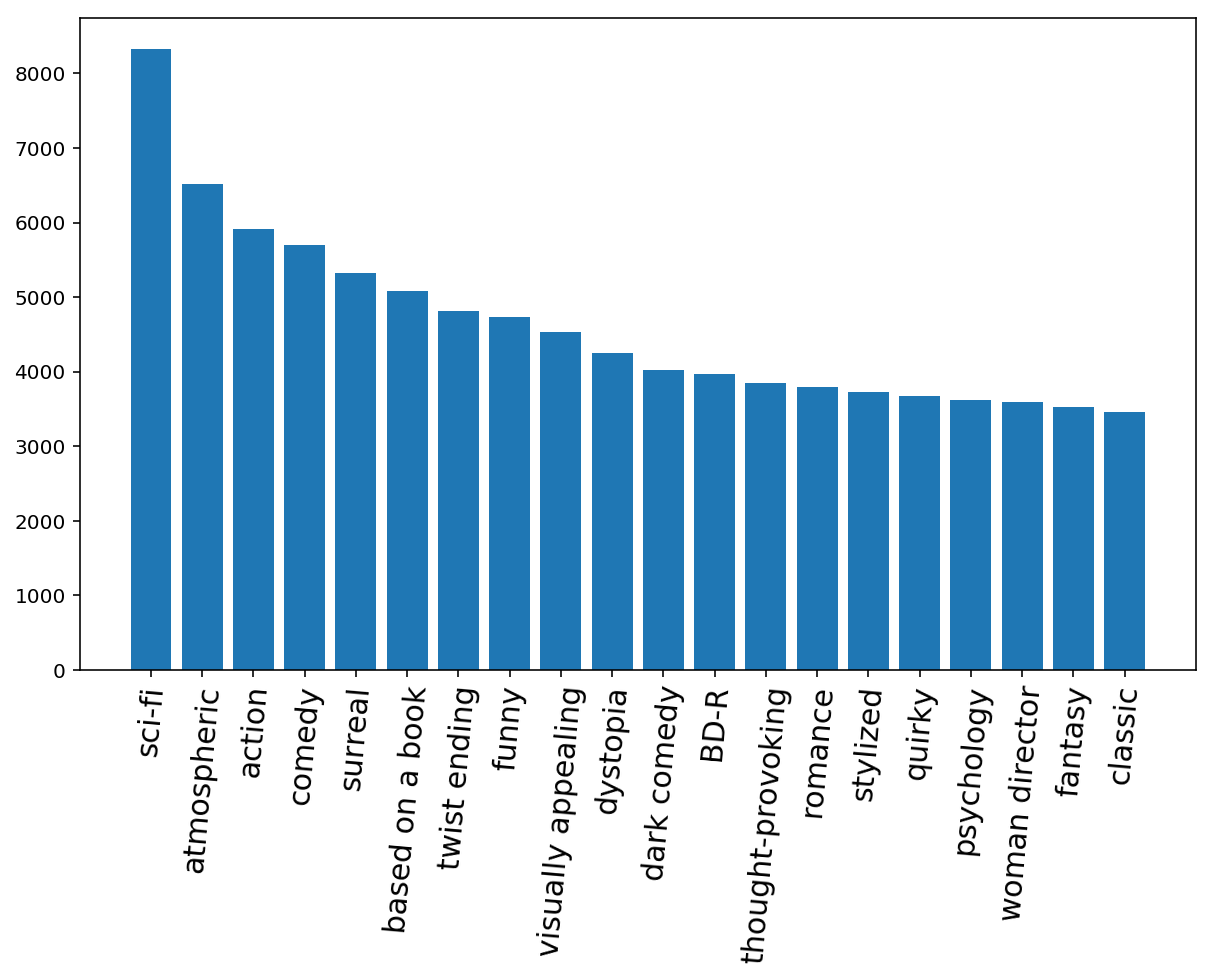

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [23]:
movies.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [48]:
movie_rating_cnt = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .join(movies)

movie_rating_cnt \
    .sortBy(lambda item: -item[1][0]) \
    .map(lambda item: (item[1][1][1], item[1][0])) \
    .take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [32]:
movie_five_cnt = ratings \
    .filter(lambda r: r.rating == 5) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .join(movies)

movie_five_cnt \
    .sortBy(lambda item: -item[1][0]) \
    .map(lambda item: (item[1][1][1], item[1][0])) \
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

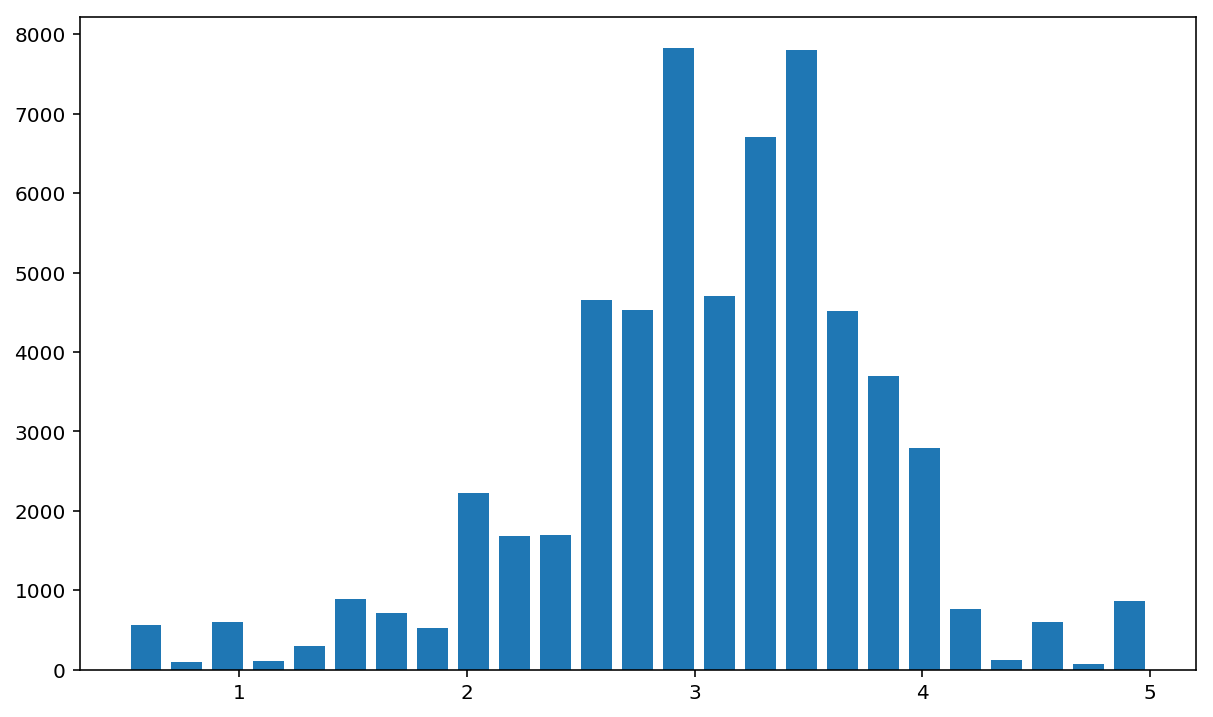

In [46]:
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(movie_avg_rating.values().collect(), bins=25, rwidth=0.75)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [60]:
import numpy as np
import math

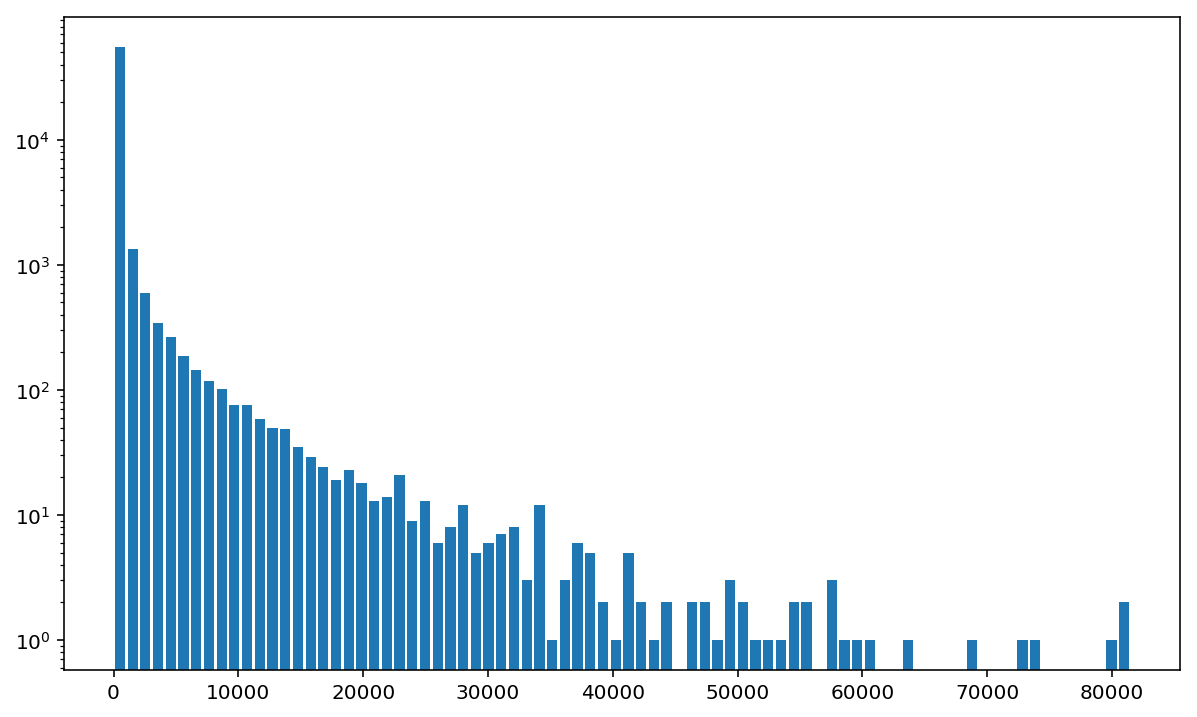

In [74]:
counts = movie_rating_cnt.map(lambda item: item[1][0]).collect()

f, ax = plt.subplots(figsize=(10, 6))
plt.hist(counts, log=True, bins=80, rwidth=0.8)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [55]:
movies = sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(','))
    
genres = movies \
    .flatMap(lambda item: item[-1].split('|')) \
    .filter(lambda item: item != 'genres')

genres_cnt = genres \
    .map(lambda item : (item, 1)) \
    .reduceByKey(lambda x, y: x + y)

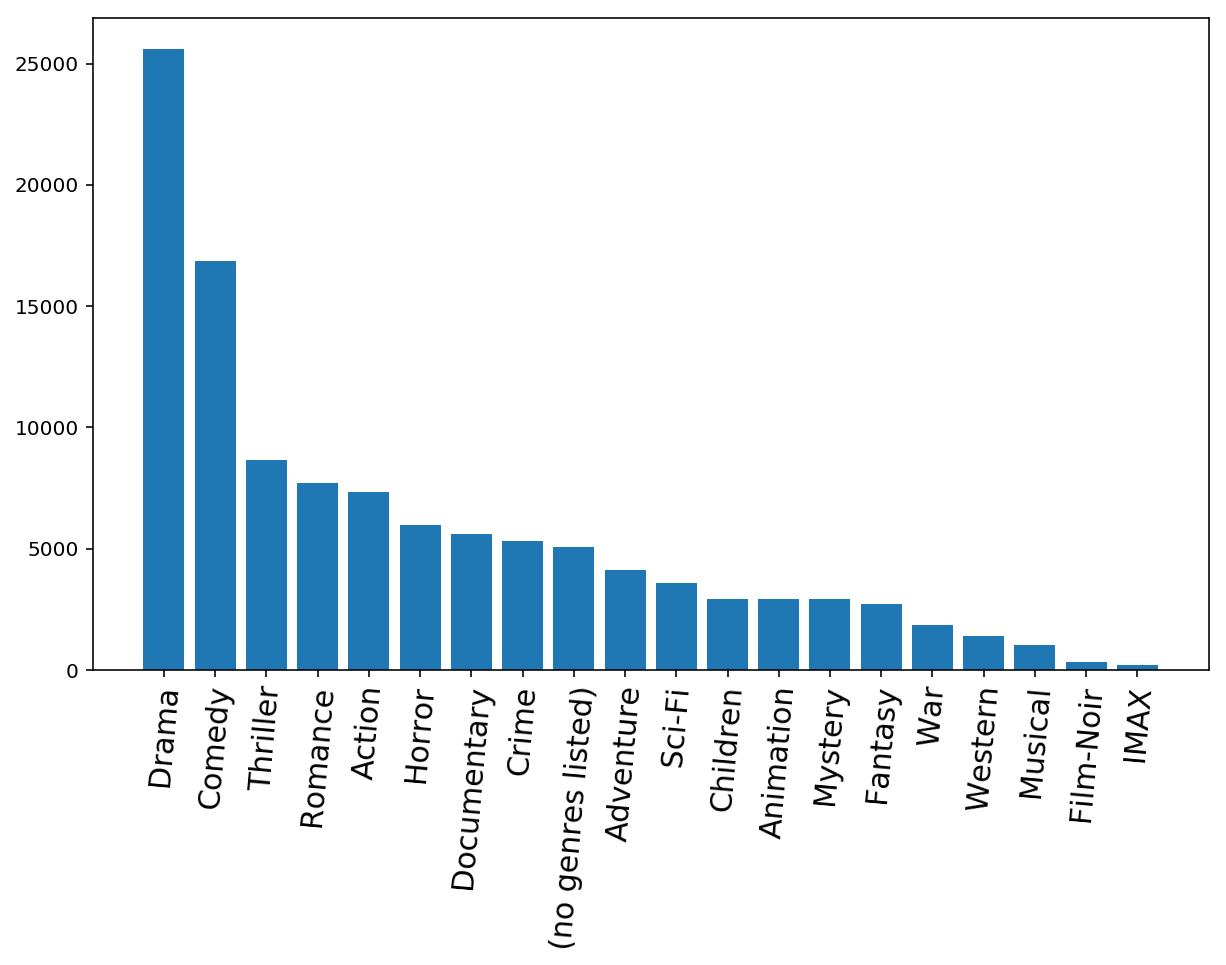

In [56]:
keys, values = zip(*sorted(genres_cnt.collect(), 
                           key=lambda x: -x[1]))

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [38]:
import json

In [53]:
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
tmdb = sc.textFile(TMDB_PATH)

In [54]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
links = sc.textFile(LINKS_PATH)
links = links \
    .map(lambda s: s.split(',')) \
    .filter(lambda item: item[0].isdigit() and item[2].isdigit()) \
    .map(lambda item: (int(item[2]), int(item[0])))

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [152]:
movies = sc.textFile(MOVIES_PATH)
genres = movies \
    .filter(lambda s: s.split(',')[0].isdigit() and ('no genres listed' not in s)) \
    .map(lambda s: s.split(','))\
    .map(lambda s: (int(s[0]), s[-1].split('|')))\
    .flatMap(lambda item: [(item[0], gen) for gen in item[1]])

In [157]:
tmdb = sc.textFile(TMDB_PATH)

rev_bud = tmdb \
    .map(lambda s: json.loads(s)) \
    .filter(lambda item: item.get('revenue', -1) > 0) \
    .filter(lambda item: item.get('budget', -1) > 0) \
    .keyBy(lambda item: int(item['id'])) \
    .mapValues(lambda item: (item['revenue'], item['budget']))

In [158]:
rev_bud = rev_bud.join(links)\
    .map(lambda x: (x[1][1], x[1][0]))

rev_bud_genre = rev_bud.join(genres) \
    .map(lambda x: (x[1][1], x[1][0]))

In [159]:
ROI = rev_bud_genre \
    .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
    .mapValues(lambda x: x[0] / x[1]) \
    .collect()

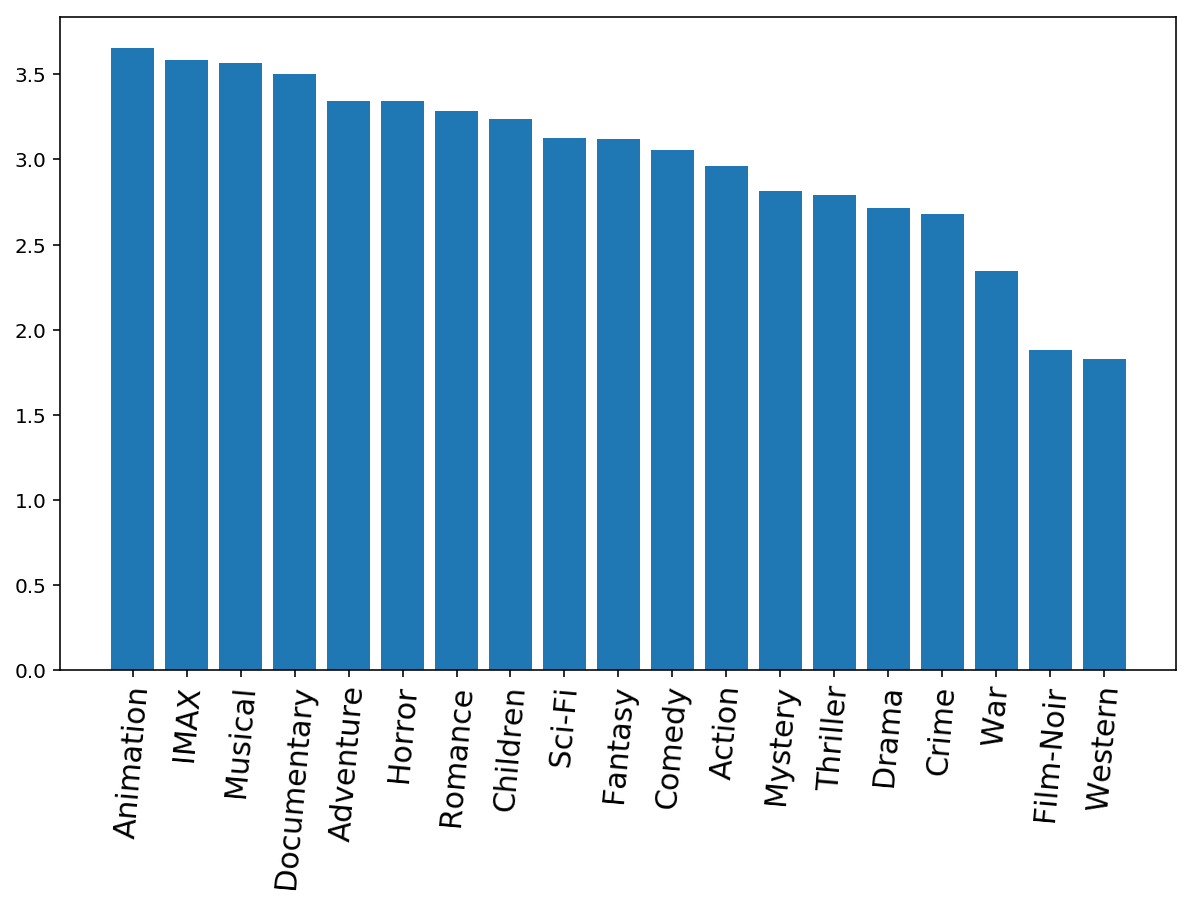

In [160]:
keys, values = zip(*sorted(ROI, key= lambda x:x[1], reverse=True))

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()